[0.531233,2.10581e-05,0.000195627,0.109597,0.000974081,0.0742937,0.0748721,0.0220993]
[0.413736, 0.688691]
[1.71061e-07, 0.000989401]
[8.8457e-07, 0.00253307]
[0.075988, 0.157431]
[3.09989e-06, 0.00599298]
[0.0512853, 0.107248]
[0.0477892, 0.109226]
[0.0130348, 0.0343203]


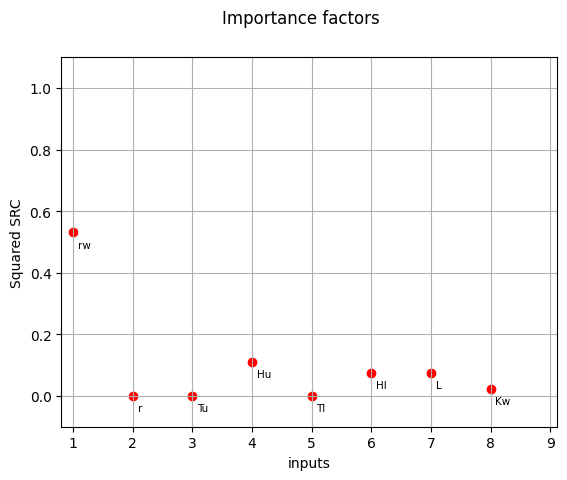

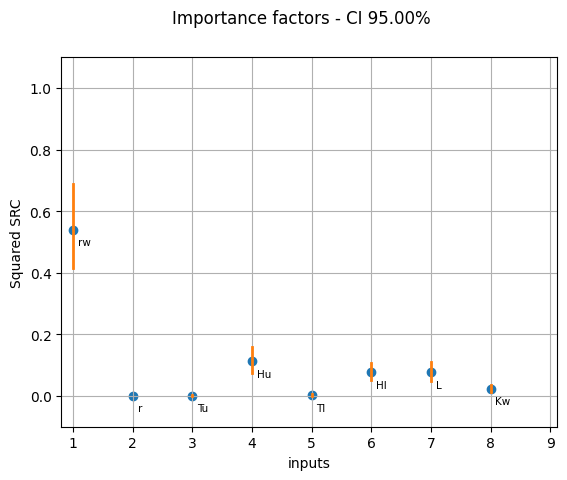

In [10]:
import openturns as ot
import openturns.viewer as otv
import importlib.util
import sys
import os

# Function to load a module from a file
def load_function_and_problem(module_name, file_path):
    if not os.path.exists(file_path):
        raise FileNotFoundError(f"File {file_path} does not exist.")
    
    spec = importlib.util.spec_from_file_location(module_name, file_path)
    if spec is None:
        raise ImportError(f"Could not load the module from {file_path}.")
    
    module = importlib.util.module_from_spec(spec)
    sys.modules[module_name] = module
    spec.loader.exec_module(module)
    return module.model, module.problem

# Function to create OpenTURNS distributions from the problem definition
def create_distributions(problem):
    distributions = ot.DistributionCollection()
    for dist_info in problem['distributions']:
        dist_type = dist_info['type']
        params = dist_info['params']
        if dist_type == 'Uniform':
            distributions.add(ot.Uniform(*params))
        elif dist_type == 'Normal':
            distributions.add(ot.Normal(*params))
        elif dist_type == 'LogNormalMuSigma':
            distributions.add(ot.ParametrizedDistribution(ot.LogNormalMuSigma(*params)))
        elif dist_type == 'LogNormal':
            distributions.add(ot.LogNormal(*params))
        elif dist_type == 'Beta':
            distributions.add(ot.Beta(*params))
        elif dist_type == 'Gumbel':
            distributions.add(ot.Gumbel(*params))
        elif dist_type == 'Triangular':
            distributions.add(ot.Triangular(*params))
        else:
            raise ValueError(f"Unsupported distribution type: {dist_type}")
    return ot.ComposedDistribution(distributions)

def main(module_name, file_path):
    function_of_interest, problem = load_function_and_problem(module_name, file_path)

    # Define the OpenTURNS model
    ot_model = ot.PythonFunction(problem['num_vars'], 1, function_of_interest)
    
    # Create the input distribution
    distribution = create_distributions(problem)

    # Produce a pair of input and output sample
    ot.RandomGenerator.SetSeed(0)
    N = 100
    X = distribution.getSample(N)
    Y = ot_model(X)

    # Compute squared SRC indices
    importance_factors = ot.CorrelationAnalysis(X, Y).computeSquaredSRC()
    print(importance_factors)

    # Plot the squared SRC indices
    input_names = problem['names']
    graph = ot.SobolIndicesAlgorithm.DrawCorrelationCoefficients(
        importance_factors, input_names, "Importance factors"
    )
    graph.setYTitle("Squared SRC")
    _ = otv.View(graph)

    # Compute confidence intervals
    bootstrap_size = 500
    src_boot = ot.Sample(bootstrap_size, problem['num_vars'])
    for i in range(bootstrap_size):
        selection = ot.BootstrapExperiment.GenerateSelection(N, N)
        X_boot = X[selection]
        Y_boot = Y[selection]
        src_boot[i, :] = ot.CorrelationAnalysis(X_boot, Y_boot).computeSquaredSRC()

    # Compute bootstrap quantiles
    alpha = 0.05
    src_lb = src_boot.computeQuantilePerComponent(alpha / 2.0)
    src_ub = src_boot.computeQuantilePerComponent(1.0 - alpha / 2.0)
    src_interval = ot.Interval(src_lb, src_ub)
    print(src_interval)

    def draw_importance_factors_with_bounds(
        importance_factors, input_names, alpha, importance_bounds
    ):
        """
        Plot importance factors indices with confidence bounds of level 1 - alpha.

        Parameters
        ----------
        importance_factors : Point(dimension)
            The importance factors.
        input_names : list(str)
            The names of the input variables.
        alpha : float, in [0, 1]
            The complementary confidence level.
        importance_bounds : Interval(dimension)
            The lower and upper bounds of the importance factors

        Returns
        -------
        graph : Graph
            The importance factors indices with lower and upper 1-alpha confidence intervals.
        """
        dim = importance_factors.getDimension()
        lb = importance_bounds.getLowerBound()
        ub = importance_bounds.getUpperBound()
        palette = ot.Drawable.BuildDefaultPalette(2)
        graph = ot.SobolIndicesAlgorithm.DrawCorrelationCoefficients(
            importance_factors, input_names, "Importance factors"
        )
        graph.setColors([palette[0], "black"])
        graph.setYTitle("Squared SRC")

        # Add confidence bounds
        for i in range(dim):
            curve = ot.Curve([1 + i, 1 + i], [lb[i], ub[i]])
            curve.setLineWidth(2.0)
            curve.setColor(palette[1])
            graph.add(curve)
        return graph

    # Plot the SRC indices mean and confidence intervals
    src_mean = src_boot.computeMean()
    graph = draw_importance_factors_with_bounds(src_mean, input_names, alpha, src_interval)
    graph.setTitle(f"Importance factors - CI {(1.0 - alpha) * 100:.2f}%")
    _ = otv.View(graph)

    otv.View.ShowAll()

# Run the main function
if __name__ == "__main__":
    module_name = "FloodModel"
    file_path = "examples/Water.py"
    main(module_name, file_path)
